# Country Guessing Game

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.625, 0.5, '  False')]

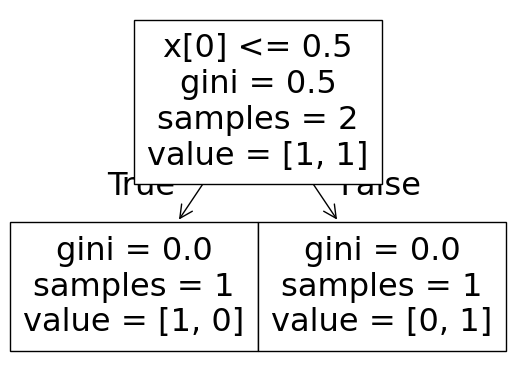

In [6]:
from sklearn import tree

# X => Feature values such as population range continent, etc.
# each element of array is to be a fact of the country (e.g. "80'000'000 => population of germany")
X = [[0, 0], [1, 1]]

# Y => country which the element of X refers to
# for the above example => "germany"
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

clf.predict([[2., 2.]])